In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Create 2 moons dataset
n_samples = 1000
noise = 0.1
X, y = make_moons(n_samples=n_samples, noise=noise, random_state=88)

# Convert to PyTorch tensors
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).long().to(device)

print(f"Dataset shape: {X_tensor.shape}")
print(f"Labels shape: {y_tensor.shape}")
#print(f"Number of samples per class: {torch.bincount(y_tensor)}")

Dataset shape: torch.Size([1000, 2])
Labels shape: torch.Size([1000])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

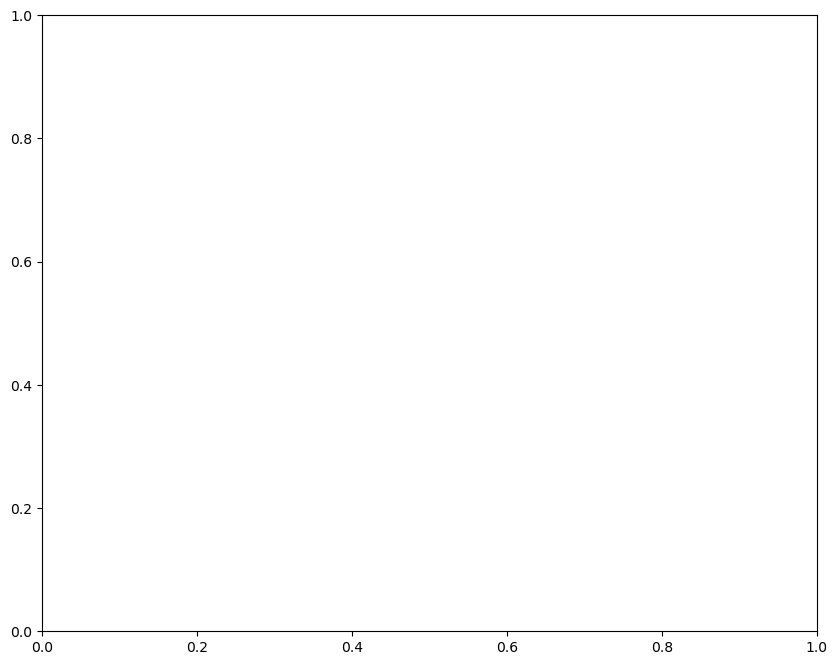

In [3]:
# Plot the 2 moons dataset
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c=y_tensor, cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Class')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('2 Moons Dataset', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
model = nn.Sequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
  (7): Sigmoid()
)

In [6]:
y = model(X_tensor)

: 

In [ ]:
y = (y < 0.5).to(torch.int32)

/tmp/ipykernel_67437/1718290394.py:52: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(X_tensor[~correct_mask, 0], X_tensor[~correct_mask, 1],


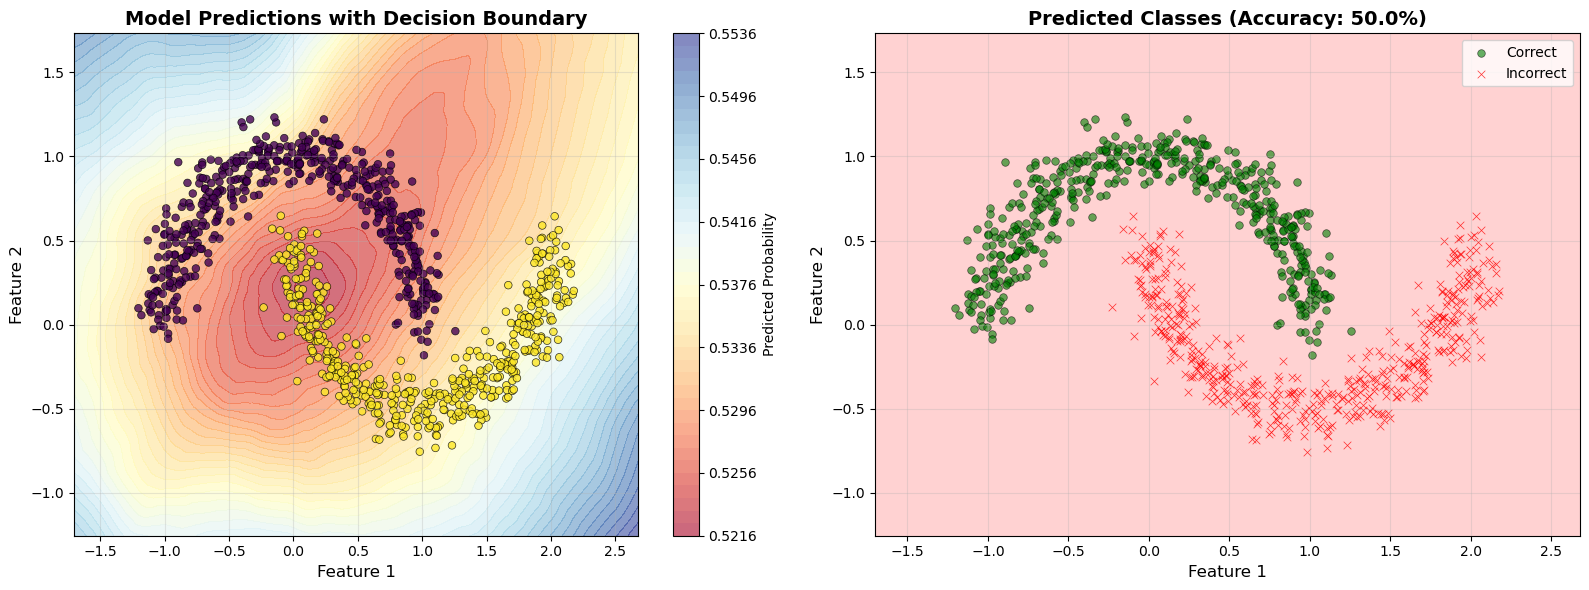

In [ ]:
# Plot model predictions with decision boundary
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get the data range for creating a mesh
x_min, x_max = X_tensor[:, 0].min() - 0.5, X_tensor[:, 0].max() + 0.5
y_min, y_max = X_tensor[:, 1].min() - 0.5, X_tensor[:, 1].max() + 0.5

# Create a mesh grid for decision boundary visualization
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

# Get model predictions on the grid
model.eval()
with torch.no_grad():
    grid_pred = model(grid_points)
    grid_pred_binary = (grid_pred < 0.5).to(torch.int32).numpy()
    grid_pred_proba = grid_pred.numpy()

# Reshape for plotting
Z_binary = grid_pred_binary.reshape(xx.shape)
Z_proba = grid_pred_proba.reshape(xx.shape)

# Plot 1: Decision boundary with probability contours
ax1 = axes[0]
contour = ax1.contourf(xx, yy, Z_proba, levels=50, cmap='RdYlBu', alpha=0.6)
ax1.contour(xx, yy, Z_proba, levels=[0.5], colors='black', linewidths=2, linestyles='--')
scatter1 = ax1.scatter(X_tensor[:, 0], X_tensor[:, 1], c=y_tensor, 
                       cmap='viridis', s=30, alpha=0.8, edgecolors='k', linewidth=0.5)
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.set_title('Model Predictions with Decision Boundary', fontsize=14, fontweight='bold')
plt.colorbar(contour, ax=ax1, label='Predicted Probability')
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted classes vs True classes
ax2 = axes[1]
# Get model predictions on actual data
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_tensor)
    y_pred = (y_pred_proba < 0.5).to(torch.int32).squeeze()

# Plot decision regions
ax2.contourf(xx, yy, Z_binary, levels=[-0.5, 0.5, 1.5], colors=['#FF6B6B', '#4ECDC4'], alpha=0.3)
ax2.contour(xx, yy, Z_binary, levels=[0.5], colors='black', linewidths=2)

# Plot points: correct predictions in green, incorrect in red
correct_mask = (y_pred.squeeze() == y_tensor)
ax2.scatter(X_tensor[correct_mask, 0], X_tensor[correct_mask, 1], 
           c='green', s=30, alpha=0.6, edgecolors='k', linewidth=0.5, label='Correct')
ax2.scatter(X_tensor[~correct_mask, 0], X_tensor[~correct_mask, 1], 
           c='red', s=30, alpha=0.8, edgecolors='k', linewidth=0.5, marker='x', label='Incorrect')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_title(f'Predicted Classes (Accuracy: {(correct_mask.sum().item()/n_samples*100):.1f}%)', 
              fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def loss(y_pred, y_true):
    return (y_pred - y_true)**2

In [ ]:
# Full batch training loop
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Training parameters
num_epochs = 10000
losses = []
accuracies = []

# Reshape y_tensor for loss calculation (needs to match model output shape)
y_tensor_reshaped = y_tensor.float().unsqueeze(1)

print("Starting training...")
print(f"Initial model parameters:")
for name, param in model.named_parameters():
    print(f"  {name}: {param.data}")

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # Forward pass - process entire dataset at once (full batch)
    y_pred = model(X_tensor)
    
    # Calculate loss
    loss = criterion(y_pred, y_tensor_reshaped)
    
    # Backward pass
    optimizer.zero_grad()  # Clear gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update parameters
    
    # Calculate accuracy
    with torch.no_grad():
        y_pred_binary = (y_pred > 0.5).float()
        accuracy = (y_pred_binary == y_tensor_reshaped).float().mean()
    
    # Store metrics
    losses.append(loss.item())
    accuracies.append(accuracy.item())
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

print("\nTraining completed!")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Final accuracy: {accuracies[-1]:.4f}")

Starting training...
Initial model parameters:
  0.weight: tensor([[ 0.6046, -0.5298],
        [ 0.3852,  0.3858],
        [-0.2074,  0.3999],
        [ 0.0278,  0.2076],
        [-0.2942, -0.1003],
        [-0.2690,  0.4397],
        [-0.1505,  0.2594],
        [ 0.0124, -0.2101],
        [ 0.1452, -0.3108],
        [ 0.0764, -0.2271],
        [-0.5782, -0.6935],
        [ 0.0446, -0.5895],
        [-0.5425,  0.4931],
        [-0.1865, -0.5288],
        [-0.0027,  0.4207],
        [ 0.2545, -0.3615],
        [ 0.1132, -0.0491],
        [ 0.3317,  0.0277],
        [ 0.5776,  0.6286],
        [ 0.3717, -0.4311],
        [ 0.2912, -0.2829],
        [-0.3895,  0.2512],
        [-0.1866, -0.6703],
        [-0.0792, -0.5172],
        [ 0.4695,  0.3974],
        [ 0.4769, -0.3516],
        [-0.5780,  0.5898],
        [ 0.1375,  0.1275],
        [ 0.4707,  0.4862],
        [ 0.3592, -0.2989],
        [ 0.1358,  0.4135],
        [-0.0161,  0.1517],
        [ 0.4766, -0.2121],
        [-0.5605,

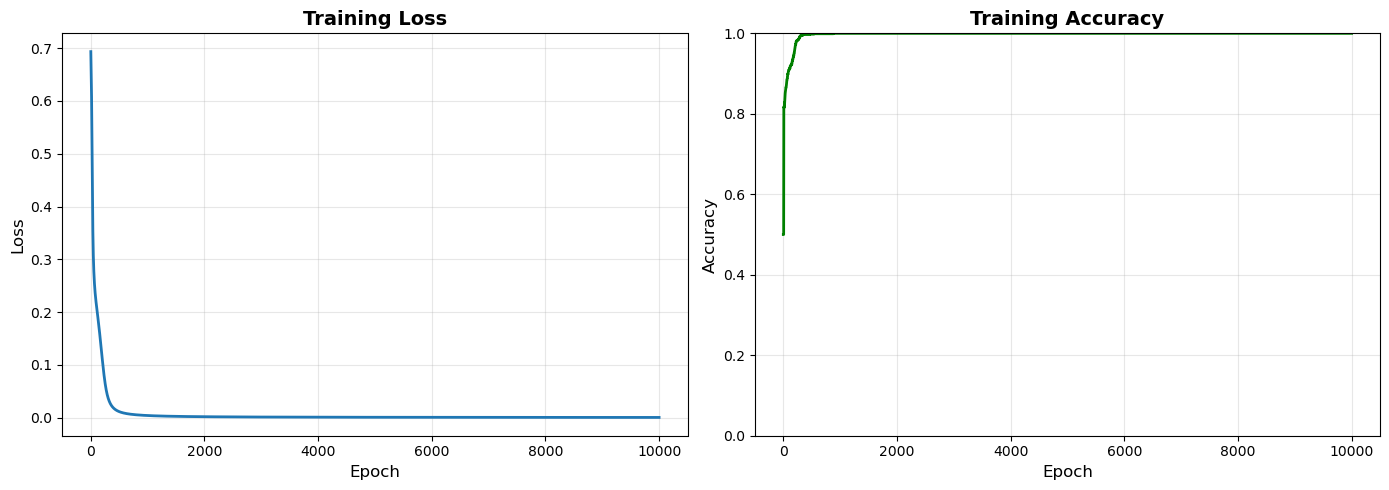

In [ ]:
# Plot training progress
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(losses, linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(accuracies, linewidth=2, color='green')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

/tmp/ipykernel_67437/2214466696.py:55: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(X_tensor[~correct_mask, 0], X_tensor[~correct_mask, 1],


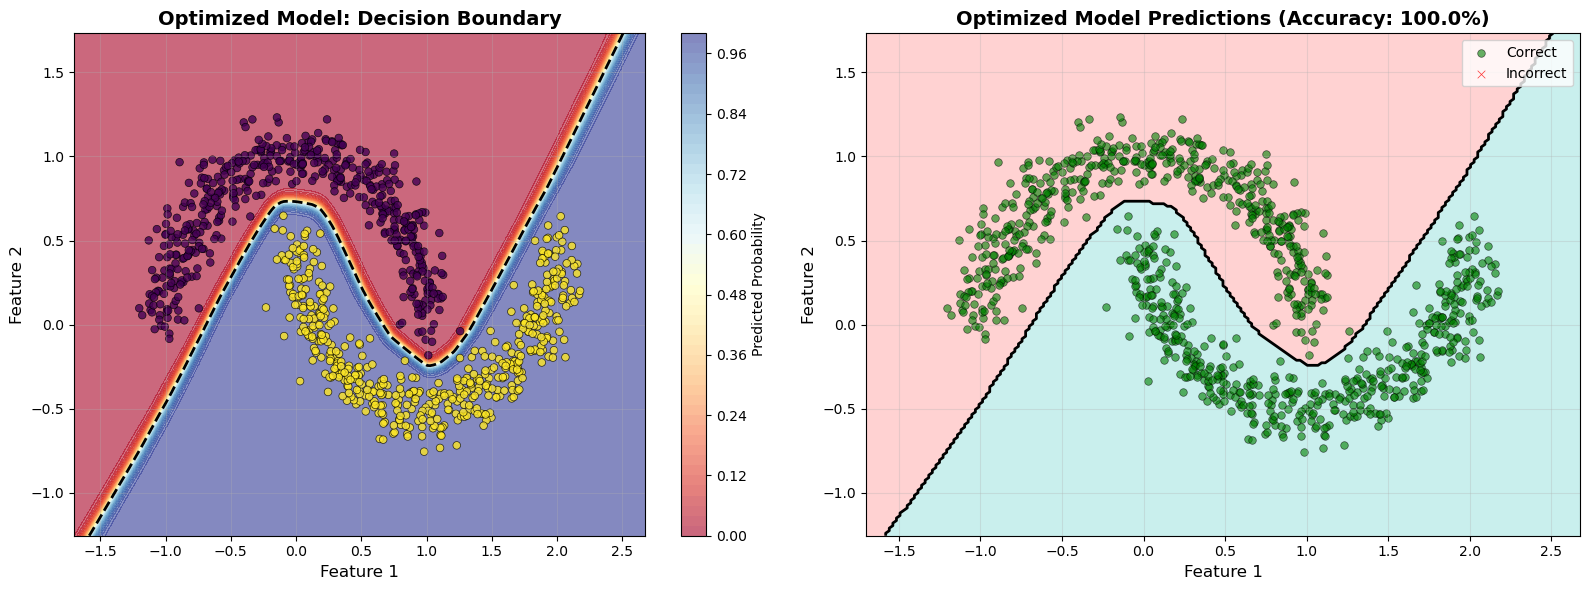


Optimized Model Performance:
  Final Accuracy: 100.00%
  Correct predictions: 1000/1000
  Incorrect predictions: 0/1000


In [ ]:
# Plot predictions of the optimized (trained) model
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get the data range for creating a mesh
x_min, x_max = X_tensor[:, 0].min() - 0.5, X_tensor[:, 0].max() + 0.5
y_min, y_max = X_tensor[:, 1].min() - 0.5, X_tensor[:, 1].max() + 0.5

# Create a mesh grid for decision boundary visualization
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

# Get model predictions on the grid (using trained model)
model.eval()
with torch.no_grad():
    grid_pred = model(grid_points)
    grid_pred_binary = (grid_pred > 0.5).to(torch.int32).numpy()
    grid_pred_proba = grid_pred.numpy()
    
    # Get predictions on actual data
    y_pred_proba = model(X_tensor)
    y_pred = (y_pred_proba > 0.5).to(torch.int32).squeeze()

# Reshape for plotting
Z_binary = grid_pred_binary.reshape(xx.shape)
Z_proba = grid_pred_proba.reshape(xx.shape)

# Calculate final accuracy
y_tensor_reshaped = y_tensor.float().unsqueeze(1)
y_pred_reshaped = y_pred.float().unsqueeze(1)
final_accuracy = (y_pred_reshaped == y_tensor_reshaped).float().mean().item()

# Plot 1: Decision boundary with probability contours
ax1 = axes[0]
contour = ax1.contourf(xx, yy, Z_proba, levels=50, cmap='RdYlBu', alpha=0.6)
ax1.contour(xx, yy, Z_proba, levels=[0.5], colors='black', linewidths=2, linestyles='--')
scatter1 = ax1.scatter(X_tensor[:, 0], X_tensor[:, 1], c=y_tensor, 
                       cmap='viridis', s=30, alpha=0.8, edgecolors='k', linewidth=0.5)
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.set_title('Optimized Model: Decision Boundary', fontsize=14, fontweight='bold')
plt.colorbar(contour, ax=ax1, label='Predicted Probability')
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted classes vs True classes
ax2 = axes[1]
# Plot decision regions
ax2.contourf(xx, yy, Z_binary, levels=[-0.5, 0.5, 1.5], colors=['#FF6B6B', '#4ECDC4'], alpha=0.3)
ax2.contour(xx, yy, Z_binary, levels=[0.5], colors='black', linewidths=2)

# Plot points: correct predictions in green, incorrect in red
correct_mask = (y_pred.squeeze() == y_tensor)
ax2.scatter(X_tensor[correct_mask, 0], X_tensor[correct_mask, 1], 
           c='green', s=30, alpha=0.6, edgecolors='k', linewidth=0.5, label='Correct')
ax2.scatter(X_tensor[~correct_mask, 0], X_tensor[~correct_mask, 1], 
           c='red', s=30, alpha=0.8, edgecolors='k', linewidth=0.5, marker='x', label='Incorrect')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.set_title(f'Optimized Model Predictions (Accuracy: {final_accuracy*100:.1f}%)', 
              fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimized Model Performance:")
print(f"  Final Accuracy: {final_accuracy*100:.2f}%")
print(f"  Correct predictions: {correct_mask.sum().item()}/{n_samples}")
print(f"  Incorrect predictions: {(~correct_mask).sum().item()}/{n_samples}")